In [14]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import certifi
import ssl
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
context = ssl.create_default_context(cafile=certifi.where())

In [15]:


# define urls for per game and advanced stats
#extracting data from site
def get_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
    
 
    data = []
    if url[-13:]=="advanced.html":
        headers = [th.text.strip() for th in table.find_all('th') if th.text.strip()!=""][7:]
        for tr in table.find_all('tr')[1:]:
            if str(tr)[:16]=="<tr class=\"thead" or str(tr)[:16]=="<tr class=\"itali":
                continue
            row = np.array([td.text.strip() for td in tr.find_all('td')[6:] if "DUMMY" not in str(td)])
            data.append(row)
    else:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        for tr in table.find_all('tr')[1:]:
            
            if str(tr)[:16]=="<tr class=\"thead"or str(tr)[:16]=="<tr class=\"itali" :
                
                if data[-1][4]=="TOT":
                    data[-1][4]=[td.text.strip() for td in tr.find_all('td') ][3]
                    
                continue
            
            
            row = np.append([0],np.array([td.text.strip() for td in tr.find_all('td') ]))
            
            
            data.append(row)
          
    headers=headers[:row.size]
    arr=np.array(data)
      

    return arr,headers


In [18]:
#creating data frame

per_game_url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'
advanced_url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'
def data_frame():
    for i in range(1997,2024):
        per_game_for_seas,per_game_headers=get_data(per_game_url.format(i))
        per_game_for_seas=np.insert(per_game_for_seas,3,i,axis=1)
        advanced_for_seas,adnvanced_headers=get_data(advanced_url.format(i))
        temp_full=np.concatenate((per_game_for_seas,advanced_for_seas),axis=1)
        if i==1997:
            full=temp_full
        else:
            full=np.concatenate((full,temp_full))
        print(i)
        
    whole_data=pd.DataFrame(full)
    headers=np.concatenate((per_game_headers,adnvanced_headers))
    headers=np.insert(headers, 3,"Season")
    whole_data.columns=headers
    whole_data.Rk=[i for i in range(1,len(full)+1)]
    return whole_data

   
   

In [19]:
whole_data=data_frame()


nba_abbreviations_teams = {
    'PHO': 'Phoenix Suns',
    'WSB':'Washington Wizards',
    'ATL': 'Atlanta Hawks',
    'BOS': 'Boston Celtics',
    'BKN': 'Brooklyn Nets',
    'BRK':'Brooklyn Nets',
    'CHO':'Charlotte Hornets',
    'CHH': 'Charlotte Hornets',
    'NOK': 'New Orleans Pelicans',
    'CHI': 'Chicago Bulls',
    'CLE': 'Cleveland Cavaliers',
    'DAL': 'Dallas Mavericks',
    'DEN': 'Denver Nuggets',
    'DET': 'Detroit Pistons',
    'GSW': 'Golden State Warriors',
    'HOU': 'Houston Rockets',
    'IND': 'Indiana Pacers',
    'LAC': 'Los Angeles Clippers',
    'LAL': 'Los Angeles Lakers',
    'MEM': 'Memphis Grizzlies',
    'MIA': 'Miami Heat',
    'MIL': 'Milwaukee Bucks',
    'MIN': 'Minnesota Timberwolves',
    'NOP': 'New Orleans Pelicans',
    'NYK': 'New York Knicks',
    'OKC': 'Oklahoma City Thunder',
    'ORL': 'Orlando Magic',
    'PHI': 'Philadelphia 76ers',
    'PHX': 'Phoenix Suns',
    'POR': 'Portland Trail Blazers',
    'SAC': 'Sacramento Kings',
    'SAS': 'San Antonio Spurs',
    'TOR': 'Toronto Raptors',
    'UTA': 'Utah Jazz',
    'WAS': 'Washington Wizards',
    'CHA': 'Charlotte Hornets', # Became Charlotte Hornets in 2014
    'NJN': 'New Jersey Nets',   # Moved to Brooklyn and became Brooklyn Nets in 2012
    'NOH': 'New Orleans Hornets', # Became New Orleans Pelicans in 2013
    'SEA': 'Seattle SuperSonics', # Relocated to Oklahoma City and became Oklahoma City Thunder in 2008
    'VAN': 'Memphis Grizzlies', # Relocated to Memphis and became Memphis Grizzlies in 2001
}

1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [20]:
whole_data.to_csv("whole_data.csv")

numerical_data=pd.DataFrame(whole_data.values[:,6:],columns=whole_data.columns[6:])



In [156]:
p_id=pd.DataFrame(np.zeros((whole_data.shape[0],8)),columns=["Rk","Player","team", "season","Age","seed","cons_mvp","mvp_votes"])
p_id.Rk=whole_data.Rk
p_id.Age=whole_data.Age
p_id.Player=whole_data.Player
p_id.season=whole_data.Season
p_id.team=whole_data.Tm



In [114]:
def givehtml(s):
    wikiurl="https://en.wikipedia.org/wiki/{}%E2%80%93{}_NBA_season"
    if s<2009 and s>=1999:
        page=urlopen(wikiurl.format(str(s),"0"+str((s+1)%100)))
    
    else:
        page=urlopen(wikiurl.format(str(s),str((s+1)%100)))
    htmllang=page.read()
    htmlstr=htmllang.decode("utf-8")
    

    return htmlstr


    
def cut_data(htmlstr):
    
    startEastv1=htmlstr.index("<span class=\"mw-headline\" id=\"By_conference\">By conference</span>")
    startEast=htmlstr[startEastv1:].index("season")+1+startEastv1
    finishEast=htmlstr[startEast:].index("West")+startEast
    startWest=finishEast
    finishWest=htmlstr[startWest:].index("Playoffs")+startWest
    east_data=htmlstr[startEast:finishEast]
    west_data=htmlstr[startWest:finishWest]

    return east_data,west_data


def get_stands(results):
    for i in range(1996,2023):
     
        east_data,west_data=cut_data(givehtml(i))
        res_dictionary={}
        #east
       
        start=east_data.find("season")
        n=30
        while start >= 0 and n > 1:
            start = east_data.find("season", start+1)
            if n%2==0:
                  sign=east_data[start:].find("<")+start
                  res_dictionary[east_data[start+8:sign]]=int((32-n)/2)
            n -= 1
        
        #west
        if i>=2004:
            start=west_data.find("season")
            n=30
            while start >= 0 and n > 1:
                start = west_data.find("season", start+1)
                if n%2==0:
                  sign=west_data[start:].find("<")+start
                  res_dictionary[west_data[start+8:sign]]=int((32-n)/2)
                n-=1
        else:
            n=28
            start=west_data.find("season")
      
            while start >= 0 and n > 1:
                start = west_data.find("season", start+1)
                if n%2==0:
                  sign=west_data[start:].find("<")+start
                  res_dictionary[west_data[start+8:sign]]=int((30-n)/2)
                n-=1
        results.append(res_dictionary)        

     
    
        

In [116]:
#changing past team names
results=[] 
get_stands(results)


for i in results:
    try:
       val=i["Washington Bullets"]
       del i["Washington Bullets"]
       i["Washington Wizards"]=val
    except:
         pass
    
    try:
        val=i['Vancouver Grizzlies']
        del i['Vancouver Grizzlies']
        i['Memphis Grizzlies']=val
    except:pass
    try:
        val=i['Charlotte Bobcats']
        del i['Charlotte Bobcats']
        i['Charlotte Hornets']=val
    except:pass
    try:
        val=i['New Orleans/Oklahoma City Hornets']
        del i['New Orleans/Oklahoma City Hornets']
        i['New Orleans Pelicans']=val
    except:pass
    
   
#seeding
for i,v in enumerate(p_id.values):
       
    
            p_id.at[i,"seed"]=float(results[int(v[3])-1997][nba_abbreviations_teams[v[2]]])
if p_id.shape[0]<1000:
    combined=pd.DataFrame(np.concatenate((p_id.values,numerical_data),axis=1),columns=np.append(p_id.columns,numerical_data.columns))
    combined.to_csv("23-24data.csv")    
            
       
        

        




In [119]:
#scraping data
def get_mvp_vote_data(url,mvp_data_storage):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
 
    this_year_votes={}
    current=""
    column=0
    for td in table.find_all('td'):
        
        if column%19==0:
            current=td.text.strip()
        elif column%19==6:
            points=float(td.text.strip())
            this_year_votes[current]=points
        column+=1
    mvp_data_storage.append(this_year_votes)

mvp_votes_url="https://www.basketball-reference.com/awards/awards_{}.html"
def gather_mvp_voting():
    mvp_data_storage=[]
    for i in range(1997,2024):
        get_mvp_vote_data(mvp_votes_url.format(i),mvp_data_storage)
    return mvp_data_storage
        
mvp_voting_data=gather_mvp_voting()
print(mvp_voting_data)

[{'Karl Malone': 0.857, 'Michael Jordan': 0.832, 'Grant Hill': 0.327, 'Tim Hardaway': 0.207, 'Glen Rice': 0.117, 'Gary Payton': 0.091, 'Hakeem Olajuwon': 0.083, 'Patrick Ewing': 0.05, 'Anthony Mason': 0.006, "Shaquille O'Neal": 0.006, 'Scottie Pippen': 0.005, 'Alonzo Mourning': 0.004, 'Dikembe Mutombo': 0.003, 'Mitch Richmond': 0.003, 'John Stockton': 0.003, 'Charles Barkley': 0.002, 'Tom Gugliotta': 0.001, 'Allen Iverson': 0.001, 'Kevin Johnson': 0.001, 'Steve Smith': 0.001}, {'Michael Jordan': 0.934, 'Karl Malone': 0.726, 'Gary Payton': 0.372, "Shaquille O'Neal": 0.268, 'Tim Duncan': 0.128, 'Tim Hardaway': 0.061, 'David Robinson': 0.031, 'Vin Baker': 0.021, 'Grant Hill': 0.02, 'Scottie Pippen': 0.012, 'Glen Rice': 0.006, 'Antoine Walker': 0.005, 'Jason Kidd': 0.004, 'John Stockton': 0.004, 'Mitch Richmond': 0.003, 'Reggie Miller': 0.002, 'Rik Smits': 0.002, 'Michael Finley': 0.001, 'Rod Strickland': 0.001}, {'Karl Malone': 0.701, 'Alonzo Mourning': 0.655, 'Tim Duncan': 0.627, 'Allen 

In [159]:
cur_year=0.0
mvp=""
cons=0.0
for i,v in enumerate(p_id.values):
    
    if p_id.at[i,"Player"][-1]=="*":
        print(p_id.at[i,"Player"])
        p_id.at[i,"Player"]= p_id.at[i,"Player"][:-1]
        print(p_id.at[i,"Player"])
    
    if p_id.at[i,"season"]!=cur_year:
        cur_year=v[3]
        cur_year_data=mvp_voting_data[int(cur_year)-1997]
        max_val=max(cur_year_data.values())
    if p_id.at[i,"Player"] in cur_year_data.keys():
    
        p_id.at[i,"mvp_votes"]=cur_year_data[p_id.at[i,"Player"]]
        
       
        if p_id.at[i,"mvp_votes"]==max_val:
            if p_id.at[i,"Player"]== mvp:
                print(p_id.at[i,"Player"])
                cons+=1
            else:
                cons=0
            mvp=p_id.at[i,"Player"]
            p_id.at[i,"cons_mvp"]=cons




p_id.to_csv("p_id.csv")

Kobe Bryant*
Kobe Bryant
Vlade Divac*
Vlade Divac
Clyde Drexler*
Clyde Drexler
Joe Dumars*
Joe Dumars
Patrick Ewing*
Patrick Ewing
Kevin Garnett*
Kevin Garnett
Tim Hardaway*
Tim Hardaway
Grant Hill*
Grant Hill
Allen Iverson*
Allen Iverson
Michael Jordan*
Michael Jordan
Jason Kidd*
Jason Kidd
Toni Kukoč*
Toni Kukoč
Karl Malone*
Karl Malone
Šarūnas Marčiulionis*
Šarūnas Marčiulionis
Reggie Miller*
Reggie Miller
Alonzo Mourning*
Alonzo Mourning
Chris Mullin*
Chris Mullin
Dikembe Mutombo*
Dikembe Mutombo
Steve Nash*
Steve Nash
Shaquille O'Neal*
Shaquille O'Neal
Hakeem Olajuwon*
Hakeem Olajuwon
Robert Parish*
Robert Parish
Gary Payton*
Gary Payton
Scottie Pippen*
Scottie Pippen
Dino Radja*
Dino Radja
Mitch Richmond*
Mitch Richmond
David Robinson*
David Robinson
Dennis Rodman*
Dennis Rodman
Arvydas Sabonis*
Arvydas Sabonis
John Stockton*
John Stockton
Ben Wallace*
Ben Wallace
Chris Webber*
Chris Webber
Dominique Wilkins*
Dominique Wilkins
Ray Allen*
Ray Allen
Charles Barkley*
Charles Barkley

In [136]:
p_id

,Rk,Player,team,season,Age,seed,cons_mvp,mvp_votes
0,1,Mahmoud Abdul-Rauf,SAC,1997,27,9.0,0.0,0.0
1,2,Dwyane Wade,VAN,1997,20,14.0,0.0,0.0
2,3,Rafael Addison,CHH,1997,32,6.0,0.0,0.0
3,4,Cory Alexander,SAS,1997,23,13.0,0.0,0.0
4,5,Jerome Allen,IND,1997,24,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...
12841,12842,Thaddeus Young,TOR,2023,34,9.0,0.0,0.0
12842,12843,Trae Young,ATL,2023,24,8.0,0.0,0.0
12843,12844,Omer Yurtseven,MIA,2023,24,7.0,0.0,0.0
12844,12845,Cody Zeller,MIA,2023,30,7.0,0.0,0.0


In [160]:
combined=pd.DataFrame(np.concatenate((p_id.values,numerical_data),axis=1),columns=np.append(p_id.columns,numerical_data.columns))

for i in combined:
    if i not in ["Rk","season","team","Player"] :
        for k,n in enumerate(combined[i]):
                if n=="":
                        combined.at[k,i]=0.0
             
for i in combined:
         if i not in ["Rk","season","team","Player"]:
                combined[i]=np.array(combined[i], dtype=float)
                combined[i]=np.array((combined[i]-min(combined[i]))/(max(combined[i])-min(combined[i])))

                


In [189]:
combined

,Rk,Player,team,season,Age,seed,cons_mvp,mvp_votes,G,GS,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Mahmoud Abdul-Rauf,SAC,1997,0.346154,NaN,0.0,0.0,0.880952,0.614458,...,0.108,0.262741,0.292818,0.168317,0.214286,0.493022,0.253820,0.319172,0.267724,0.152778
1,2,Shareef Abdur-Rahim,VAN,1997,0.076923,NaN,0.0,0.0,0.940476,0.855422,...,0.135,0.312571,0.276243,0.217822,0.223214,0.490920,0.257920,0.315904,0.270117,0.194444
2,3,Rafael Addison,CHH,1997,0.538462,NaN,0.0,0.0,0.476190,0.036145,...,0.112,0.227633,0.193370,0.108911,0.111607,0.490728,0.247111,0.320261,0.262339,0.166667
3,4,Cory Alexander,SAS,1997,0.192308,NaN,0.0,0.0,0.940476,0.072289,...,0.211,0.251416,0.209945,0.158416,0.142857,0.488243,0.257920,0.330065,0.273706,0.215278
4,5,Jerome Allen,IND,1997,0.230769,NaN,0.0,0.0,0.892857,0.012048,...,0.214,0.176670,0.165746,0.178218,0.111607,0.485567,0.247484,0.336601,0.267724,0.173611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12841,12842,Thaddeus Young,TOR,2023,0.615385,NaN,0.0,0.0,0.630952,0.108434,...,0.167,0.152888,0.220994,0.207921,0.174107,0.502390,0.250093,0.359477,0.275800,0.208333
12842,12843,Trae Young,ATL,2023,0.230769,NaN,0.0,0.0,0.857143,0.879518,...,0.152,0.369196,0.475138,0.237624,0.392857,0.505639,0.276556,0.316993,0.285372,0.416667
12843,12844,Omer Yurtseven,MIA,2023,0.230769,NaN,0.0,0.0,0.095238,0.000000,...,0.119,0.203851,0.193370,0.108911,0.107143,0.511948,0.247484,0.322440,0.263835,0.180556
12844,12845,Cody Zeller,MIA,2023,0.461538,NaN,0.0,0.0,0.166667,0.024096,...,0.158,0.204983,0.204420,0.128713,0.125000,0.509654,0.249348,0.331155,0.267125,0.180556


In [190]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
X=combined.drop(["mvp_votes","cons_mvp"],axis=1).values
y=combined.mvp_votes.values

array([[1, 'Mahmoud Abdul-Rauf', 'SAC', ..., 0.3191721132897603,
        0.26772360155548913, 0.1527777777777778],
       [2, 'Shareef Abdur-Rahim', 'VAN', ..., 0.31590413943355117,
        0.27011666168112475, 0.19444444444444445],
       [3, 'Rafael Addison', 'CHH', ..., 0.3202614379084967,
        0.2623392162728089, 0.16666666666666666],
       ...,
       [12844, 'Omer Yurtseven', 'MIA', ..., 0.3224400871459695,
        0.26383487885133117, 0.18055555555555555],
       [12845, 'Cody Zeller', 'MIA', ..., 0.3311546840958606,
        0.2671253365240802, 0.18055555555555555],
       [12846, 'Ivica Zubac', 'LAC', ..., 0.340958605664488,
        0.2728088543224649, 0.22222222222222224]], dtype=object)

In [182]:

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

label_encoder = LabelEncoder()
x_categorical = combined.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = combined.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values
 
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(X[:,3:], y)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
predictions=regressor.predict(X[:,3:])
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.6163881937605425
Mean Squared Error: 0.00017532848545072396
R-squared: 0.9473710016038658


In [192]:
X[12307:]

array([[12308, 'Precious Achiuwa', 'TOR', ..., 0.3300653594771242,
        0.26862099910260245, 0.1736111111111111],
       [12309, 'Steven Adams', 'MEM', ..., 0.34858387799564267,
        0.2772958420580317, 0.22916666666666666],
       [12310, 'Bam Adebayo', 'MIA', ..., 0.3474945533769063,
        0.27998803469937183, 0.3402777777777778],
       ...,
       [12844, 'Omer Yurtseven', 'MIA', ..., 0.3224400871459695,
        0.26383487885133117, 0.18055555555555555],
       [12845, 'Cody Zeller', 'MIA', ..., 0.3311546840958606,
        0.2671253365240802, 0.18055555555555555],
       [12846, 'Ivica Zubac', 'LAC', ..., 0.340958605664488,
        0.2728088543224649, 0.22222222222222224]], dtype=object)

In [196]:
dataset=X[12307:,3:]
predictions = regressor.predict(dataset)
res=[]

for i,v in enumerate(y[12307:]) :
    Rk=X[12307+i][0]
    print(Rk,i)
    res.append([Rk,p_id.at[Rk-1,"Player"],p_id.at[Rk-1,"season"],str(v)])
        
def last(arr):
    return float(arr[-1])
res=sorted(res, key=last,reverse=True)
sum=0
for i,v in enumerate(res):
    if i<11:
        sum+=float(v[-1])
   
res=pd.DataFrame(res)
res.to_csv("res.csv")



12308 0
12309 1
12310 2
12311 3
12312 4
12313 5
12314 6
12315 7
12316 8
12317 9
12318 10
12319 11
12320 12
12321 13
12322 14
12323 15
12324 16
12325 17
12326 18
12327 19
12328 20
12329 21
12330 22
12331 23
12332 24
12333 25
12334 26
12335 27
12336 28
12337 29
12338 30
12339 31
12340 32
12341 33
12342 34
12343 35
12344 36
12345 37
12346 38
12347 39
12348 40
12349 41
12350 42
12351 43
12352 44
12353 45
12354 46
12355 47
12356 48
12357 49
12358 50
12359 51
12360 52
12361 53
12362 54
12363 55
12364 56
12365 57
12366 58
12367 59
12368 60
12369 61
12370 62
12371 63
12372 64
12373 65
12374 66
12375 67
12376 68
12377 69
12378 70
12379 71
12380 72
12381 73
12382 74
12383 75
12384 76
12385 77
12386 78
12387 79
12388 80
12389 81
12390 82
12391 83
12392 84
12393 85
12394 86
12395 87
12396 88
12397 89
12398 90
12399 91
12400 92
12401 93
12402 94
12403 95
12404 96
12405 97
12406 98
12407 99
12408 100
12409 101
12410 102
12411 103
12412 104
12413 105
12414 106
12415 107
12416 108
12417 109
12418 110


In [179]:

# Making predictions on the same data or new data
predictions = regressor.predict(dataset)
res=pd.DataFrame(np.array([X[:,0],X[:,2],X[:,3],predictions]).reshape(-1,4),columns=["Rk","Player","season","score"])
for i,v in enumerate(predictions) :
    Rk=X[i][0]
    try:
        res.values[i]=Rk,p_id.at[Rk-1,"Player"],p_id.at[Rk-1,"season"],str(v)
    except:
        pass
res.sort_values("score",ascending=False).to_csv("res.csv")


Text(0.5, 0, 'Relative Importance')

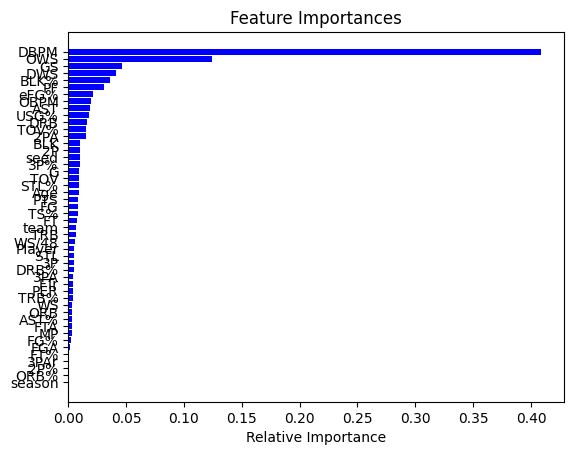

In [165]:
importances = regressor.feature_importances_

# then sort them descending
indices = np.argsort(importances)

# get the features from the original data set
features = combined.drop(["cons_mvp","mvp_votes","Rk"],axis=1).columns

# plot them with a horizontal bar chart
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [166]:
list=[]
for i,v in enumerate(importances):
    list.append([features[i],v])
list=(sorted(list,reverse=True,key=last))
for i in list:
    print(i)

['DBPM', 0.40846334021592157]
['OWS', 0.12426821265027768]
['GS', 0.04604977194844441]
['DWS', 0.041317146586780415]
['BLK%', 0.03613328033225856]
['PF', 0.030698475390226094]
['eFG%', 0.02170709615468857]
['OBPM', 0.01975504182477587]
['AST', 0.019010810627884452]
['USG%', 0.017923607793428904]
['DRB', 0.016362712160927703]
['TOV%', 0.015208006179357459]
['2PA', 0.014998992462146355]
['BLK', 0.01036521303953809]
['2P', 0.010222024668872367]
['seed', 0.010130774541953425]
['3P%', 0.010005389597447468]
['G', 0.009558775009034164]
['TOV', 0.009501067633366259]
['STL%', 0.009150093453722514]
['Age', 0.008932085153448765]
['PTS', 0.008727660601967991]
['FG', 0.008413602616653377]
['TS%', 0.008343827420774903]
['FT', 0.007653345727967828]
['team', 0.006528847489550292]
['TRB', 0.006460639183870053]
['WS/48', 0.00603064816299558]
['Player', 0.0051042887641315595]
['STL', 0.004898447837071268]
['3P', 0.004756936402787161]
['DRB%', 0.004655201347455251]
['3PA', 0.004046867266644381]
['FTr', 0.